# Kaggle March Madness 2016

In [309]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from time import time
from operator import itemgetter
from scipy.stats import randint as sp_randint
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import log_loss

from __future__ import division
from __future__ import print_function

%matplotlib inline

## Load and format data

In [258]:
# load data

results = pd.read_csv('data/ncaa_compiled_matchups.csv')
teams = pd.read_csv('data/Teams.csv')
kenpom = pd.read_csv('data/ncaa_kenpom_pretourney.csv')
seeds = pd.read_csv('data/TourneySeeds.csv')
massey = pd.read_csv('data/massey.csv')
season_results = pd.read_csv('data/ncaa_regular_season_records.csv')

teams.columns = ['Team','Team_Name']
seeds = pd.merge(seeds, teams, how='left')
seeds.columns = ['Season','Seed','Team_id','Team_Name']
seeds = pd.merge(seeds, season_results)

kenpom['Team'] = kenpom['Team'].str.strip()
massey_pivot = pd.pivot_table(massey, index=['season','team'], columns='sys_name', values='orank', fill_value=999).reset_index()

## Merge matchups and external stats

In [459]:
def merge_data(team_names, matchups, stats, ljoin = ['Season','Team_Name'], rjoin = ['Year','Team'], training_set=True):
    """Merge a dataset matchups with ['Season','Wteam','Lteam'] to kenpom and massey"""
    
    merged_stats = pd.merge(team_names, stats, left_on=ljoin, right_on=rjoin)
    join1 = pd.merge(matchups, merged_stats, left_on=['Season','Wteam'], right_on=['Season','Team_id'])
    output = pd.merge(join1, merged_stats, left_on=['Season','Lteam'], right_on=['Season','Team_id'])
    
    # feature engineering
    
#     output['win_pyth'] = output['Wins_x'] ** 2 / (output['Wins_x'] ** 2 + output['Wins_y'] ** 2)
#     output['win_perc_x'] = output.Wins_x / (output.Wins_x + output.Losses_x)
#     output['win_perc_y'] = output.Wins_y / (output.Wins_y + output.Losses_y)
#     output['win_pyth_perc'] = output['win_perc_x'] ** 2 / (output['win_perc_x'] ** 2 + output['win_perc_y'] ** 2)
    
    if training_set:
        output['score_diff'] = output['Wscore'] - output['Lscore']
    
    print('Matchups shape: %s' %(matchups[matchups.Season > 2002].shape,))
    print('Merged stats shape: %s' %(merged_stats.shape,))
    print('Output shape: %s' %(output[output.Season > 2002].shape,))
    
    massey1 = pd.merge(output, massey_pivot, left_on=['Season','Wteam'], right_on=['season','team'])
    output_massey = pd.merge(massey1, massey_pivot, left_on=['Season','Lteam'], right_on=['season','team'])

    output_massey = diff_columns(output_massey, pd.unique(massey.sys_name))
    output_massey = diff_columns(output_massey, kenpom_columns)
    
    return output_massey

def diff_columns(d, cols):
    for metric in cols:
        new_col = metric + '_diff'
        pyth_col = metric + '_pyth'
        x_col = metric + '_x'
        y_col = metric + '_y'
        d[new_col] = d[x_col] - d[y_col]
        d[pyth_col] = d[x_col] ** 2 / (d[x_col] ** 2 + d[y_col] ** 2)
    return d

kenpom_columns = ['Pythag','EffD','AdjEffD'
#                ,'Tempo','AdjTempo','OE','DE'
                 ]
results_merged_massey = merge_data(seeds, results.dropna(), kenpom)

print('Final output shape: %s' %(results_merged_massey.shape,))

massey_choose = ['AVG', 'WLK', 'DOL', 'MOR', 'POM', 'BOB', 'SAG'
                 , 'RTH', 'WOL', 'RPI', 'USA', 'CNG', 'COL']

# massey_choose = massey_pivot.columns[2:]

kenpom_only = [metric + '_diff' for metric in kenpom_columns]
                
massey_only = [metric + '_pyth' for metric in massey_choose]

columns_to_keep = ['Season','Wteam','Lteam'] + \
                    kenpom_only + massey_only + ['score_diff']


Matchups shape: (1694, 8)
Merged stats shape: (923, 24)
Output shape: (1690, 55)
Final output shape: (1690, 569)


In [487]:
def prepare_datasets(raw_data, columns_keep, season_cutoff, stochastic=False, training_set=True):
    intermediate = raw_data[columns_keep]
    
    if stochastic:
        index = np.random.permutation(raw_data.shape[0])
        training_size = raw_data.shape[0] // 100 * 99

        data_for_training = intermediate.iloc[index,:]

        train_set = intermediate[:training_size]
        test_set = intermediate[training_size:]

    else:
        data_for_training = intermediate[intermediate.Season < season_cutoff]

        train_set = intermediate[intermediate.Season < season_cutoff]
        test_set = intermediate[intermediate.Season >= season_cutoff]

    trd = train_set.iloc[:,3:-1]
    trl = train_set.iloc[:,-1]

    ttd = test_set.iloc[:,3:-1]
    ttl = test_set.iloc[:,-1]
    
    cvd = intermediate.iloc[:,3:-1]
    cvl = intermediate.iloc[:,-1] > 0

    print('Training data shape: %s' %(trd.shape,))
    print('Training labels shape: %s' %(trl.shape,))
    print('Test data shape: %s' %(ttd.shape,))
    print('Test labels shape: %s' %(ttl.shape,))
    
    return trd, trl, ttd, ttl, cvd, cvl

training_data, training_labels, \
        test_data, test_labels, \
        cv_data, cv_labels = prepare_datasets(results_merged_massey, columns_to_keep, 2015, stochastic=False)
    

Training data shape: (1556, 16)
Training labels shape: (1556,)
Test data shape: (134, 16)
Test labels shape: (134,)


## Random forest classifier


**Leaderboard rating: 0.5287**

Model accuracy of 0.724

Feature Importances:



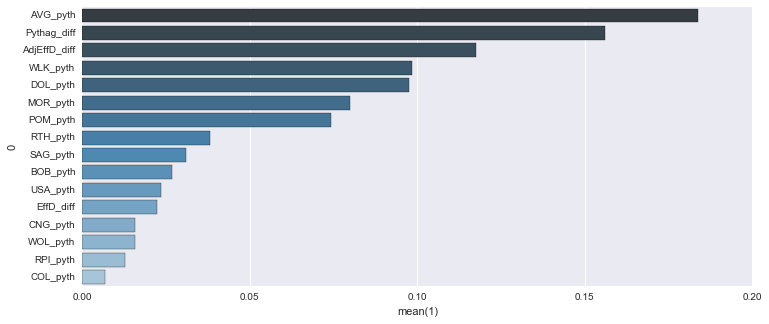

In [488]:
params = {'criterion': 'entropy'
          ,'max_depth': 3
          ,'max_features': 7
          ,'n_estimators': 500
          ,'n_jobs': -1
         }

clf = RandomForestClassifier(**params)
clf.fit(training_data, training_labels > 0)
predicted_scores = clf.predict(test_data)

predicted_probs = clf.predict_proba(test_data)

print('\n**Leaderboard rating: %.4f**'%(log_loss(test_labels > 0, predicted_probs[:,1], eps=0.03)))

print('\nModel accuracy of %.3f\n\nFeature Importances:\n' 
      %np.mean(predicted_scores == (test_labels > 0).values))

feat_import = sorted(zip(test_data.columns, clf.feature_importances_), key=lambda tup: tup[1], reverse=True)

plt.figure(figsize=(12,5))
ax = sns.barplot(pd.DataFrame(feat_import)[1], pd.DataFrame(feat_import)[0], orient="h", palette='Blues_d')
rf_probas = predicted_probs.copy()

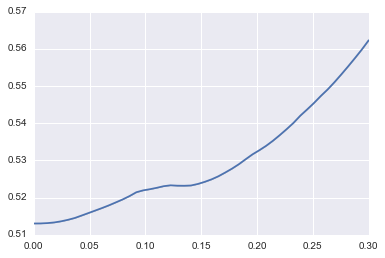

In [492]:
epsilons = np.linspace(0,0.3)
ratings = [log_loss(test_labels > 0, predicted_probs[:,1], eps=clip) for clip in epsilons]


ax = sns.tsplot(ratings, epsilons)


## Logistic Regression


**Leaderboard rating: 0.5131**

Model accuracy of 0.746

Feature Importances:



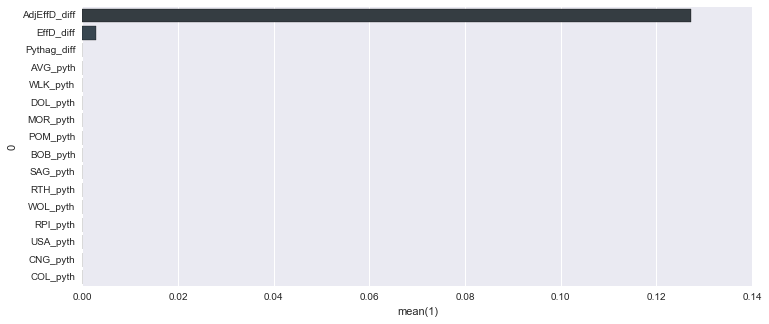

In [497]:
clf = LogisticRegression(C=0.01, penalty='l1')
clf.fit(training_data, training_labels > 0)
predicted_scores = clf.predict(test_data)

predicted_probs = clf.predict_proba(test_data)

print('\n**Leaderboard rating: %.4f**'%(log_loss(test_labels > 0, predicted_probs[:,1], eps=0.01)))

print('\nModel accuracy of %.3f\n\nFeature Importances:\n' 
      %np.mean(predicted_scores == (test_labels > 0).values))

feat_import = sorted(zip(test_data.columns, clf.coef_.reshape(len(test_data.columns),)), key=lambda tup: tup[1], reverse=True)

plt.figure(figsize=(12,5))
ax = sns.barplot(pd.DataFrame(feat_import)[1], pd.DataFrame(feat_import)[0], orient="h", palette='Blues_d')

lr_probas = predicted_probs.copy()

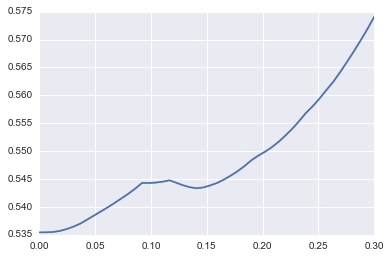

In [467]:
epsilons = np.linspace(0,0.3)
ratings = [log_loss(test_labels > 0, predicted_probs[:,1], eps=clip) for clip in epsilons]


ax = sns.tsplot(ratings, epsilons)



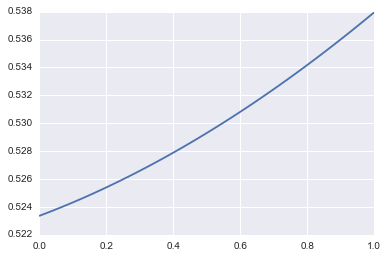

In [491]:
def return_weighted_probs(l1, l2, w1, clips):
    l1 = np.clip(l1, clips[0], 1 - clips[0]) * w1
    l2 = np.clip(l2, clips[1], 1 - clips[1]) * (1 - w1)
    return l1 + l2


alphas = np.linspace(0, 1)
ratings = [log_loss(test_labels > 0, return_weighted_probs(rf_probas, lr_probas, alpha, [0.12, 0.12]), eps=0.01) for alpha in alphas]

sns.tsplot(ratings, alphas)

## Grid search for hyperparameters

In [490]:
# Utility function to report best scores
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

def log_loss_scorer(estimator, x, y):
    y_pred = estimator.predict(x)
    return log_loss(y, y_pred, eps=0.15)

clf = RandomForestClassifier(n_estimators=250, criterion='entropy')
# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None]
              ,"max_features": [5, 7, None]
#               ,"min_samples_split": range(5, 15, 2)
#               ,"min_samples_leaf": range(5, 15, 2)
              }

# run randomized search
random_search = GridSearchCV(clf, param_grid=param_dist, cv=10, n_jobs=-1, scoring='log_loss')

start = time()
random_search.fit(cv_data, cv_labels)

report(random_search.grid_scores_)

Model with rank: 1
Mean validation score: -0.536 (std: 0.060)
Parameters: {'max_features': 5, 'max_depth': 3}

Model with rank: 2
Mean validation score: -0.537 (std: 0.061)
Parameters: {'max_features': 7, 'max_depth': 3}

Model with rank: 3
Mean validation score: -0.538 (std: 0.062)
Parameters: {'max_features': None, 'max_depth': 3}



In [496]:
clf = LogisticRegression()
# specify parameters and distributions to sample from
param_dist = {'C': [0.01, 0.1, 1, 0.001]
              ,'penalty': ['l1','l2']
            }

# run randomized search
random_search = GridSearchCV(clf, param_grid=param_dist, cv=10, scoring='log_loss')

start = time()
random_search.fit(cv_data[['AdjEffD_diff','EffD_diff']], cv_labels)

report(random_search.grid_scores_)

Model with rank: 1
Mean validation score: -0.539 (std: 0.055)
Parameters: {'penalty': 'l1', 'C': 0.01}

Model with rank: 2
Mean validation score: -0.539 (std: 0.057)
Parameters: {'penalty': 'l1', 'C': 0.1}

Model with rank: 3
Mean validation score: -0.539 (std: 0.057)
Parameters: {'penalty': 'l2', 'C': 0.01}



## Generate Scoring File

In [ ]:
sub_matchups = pd.read_csv('data/submission_file.csv')

columns_to_keep_final = [x for x in columns_to_keep if x not in ['Wscore','Lscore','score_diff']]
submission_file = merge_data(seeds, sub_matchups, kenpom, training_set=False)[columns_to_keep_final]
submission_file_data = submission_file.iloc[:,5:]

print('Final submission test data shape: %s' %(submission_file_data.shape,))

def ftostr(x):
    return str(int(x))

predicted_scores_final = clf.predict_proba(submission_file_data)
epsilon = 0.09
predicted_scores_final = np.clip(predicted_scores_final, epsilon, 1 - epsilon)

submission_file['id'] = submission_file.apply(lambda x: ftostr(x.Season) + '_' + ftostr(x.Wteam) + '_' + ftostr(x.Lteam), axis=1)

submission_output = pd.DataFrame(zip(submission_file.id, predicted_scores_final[:,1]), columns=['id','pred'])

submission_output.to_csv('submission.csv', index=False)

In [ ]:
sns.distplot(predicted_scores_final[:,1])

In [ ]:
sum(np.array([0.5, 1, 1.5]) ** 2)/6